Create a file called ref_trajectory.py. Copy the functions from week3 that enabled you to generate a trajectory given a sequence of straight/ turn commands

In [ ]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from ref_trajectory import generate_trajectory as traj

We will look at 2 ways to make a grid 

(a) Load an existing circuit (Use MS paint or anything else)

(b) Make a custom grid

Remember grid resolution is the key parameter to go from grid co-ordinates to world co-ordinates. What is the value of 1 pixel?

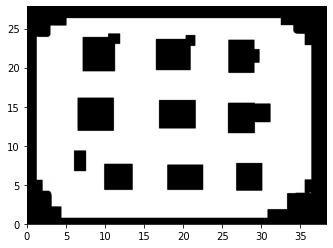

In [ ]:
grid_res = 0.05
image = Image.open('./circuit.png').convert('LA') # open the test circuit
grid_data = np.asarray(image)[:,:,0]/255

#find the shape
grid_shape = np.array(grid_data.shape)

#find the real-world extents of the grid: opposite vertices of the rectangle
x1, y1 = 0, 0
#use shape and grid_res to calculate the top-right vertex
x2, y2 = grid_shape*grid_res

#display the image using imshow()
#pay attention to the keywords origin, cmap and extent
#Default origin is top-left, but we should use 'lower'
#how should grid_data be transformed
plt.figure()

#complete
plt.imshow(grid_data, cmap = plt.cm.gray, extent=[y1,y2,x1,x2])

plt.show()

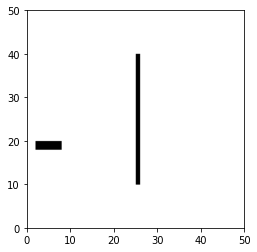

In [ ]:
#custom grid
#choose resolution and dimensions
grid_res = 0.05
grid_span =  50 # square circuit dimensions in m

#calculate grid_shape from grid
# dimensions have to be integers
grid_shape = (np.array([grid_span]*2)/grid_res).astype('int')
#Initialize 
grid_data = np.zeros(grid_shape)

#Create rectangular obstacles in world co-ordinates
#xmin, xmax, ymin, ymax
obstacles = np.array([[25, 26, 10, 40],
                       [2, 8, 18, 20]]) 
for obs in obstacles:
    # calculate obstacles extent in pixel coords
    xmin, xmax, ymin, ymax = (obs//grid_res).astype('int')
    # mark them as occupied
    grid_data[xmin:xmax ,ymin:ymax] = 1.0

#calculate the extents    
x1, y1 = 0, 0
x2, y2 = grid_span, grid_span

#imshow() from prior cell
plt.figure()
plt.imshow(1-grid_data.T, origin='lower', cmap=plt.cm.gray, extent=[x1,x2,y1,y2])

Plot the reference trajectory on the grid environment

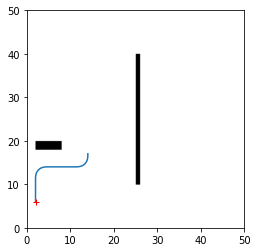

In [ ]:
#pick a suitable starting pose
start_pose = np.array([2, 6, np.pi/2])
#we will use same route as before
route = [("straight", 5),("turn", -90),("straight", 6),("turn", 90)]

#calculate ref_path from traj()
# we want it to be numpy array of dimensions (N, 3)
ref_path = traj(route, start_pose).T

#plot the grid and 
plt.imshow(1-grid_data.T, origin='lower', cmap=plt.cm.gray, extent=[x1,x2,y1,y2])
plt.plot(ref_path[:,0], ref_path[:,1])
plt.plot(start_pose[0], start_pose[1],'r+')

Let us now use circle approximation to perform collision checking. We will use w=0.8, l=1.2m as mule dimensions. Calculate the 4 vertices of the mule

Circle parameters are offset and radii

You would have to plot the mule rectangle and 3 circles

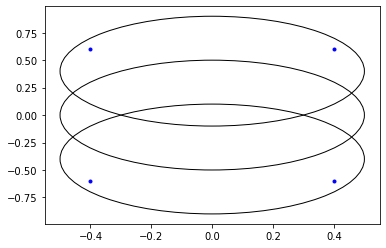

In [ ]:
w=0.8
l=1.2
mule_extents = np.array([[-w/2,-l/2],
                         [w/2, -l/2],
                         [w/2, l/2],
                         [-w/2, l/2]])
r = 0.5
l = 0.4
circles = [(0, 0, r), (0, l, r), (0, -l, r)]

plt.figure()
#plot rectangle or just the 4 vertices
for vertex in mule_extents:
    plt.plot(vertex[0], vertex[1], 'b.')

ax=plt.gca()
for x,y,rad in circles:
    #plot circle
    #you can use plt.Circle()
    ax.add_patch(plt.Circle((x,y), rad, fill=False))

Write a function to find if there is a collision given the grid and the local path

1. Rotate the 3 circle vertices along the local path

2. Check if $(x-x_c)^2 + (y-y_c)^2 < r$ and grid[x, y] = 1.0

3. Return True or False

You can assume circles variable (approximation of the vehicle dimensions) is assumed as a global variable

What do you think is a simple unit test?

In [ ]:
def circle_collision_check(grid, local_traj):
  xmax, ymax = grid.shape
  all_x = np.arange(xmax)
  all_y = np.arange(ymax)
  for xl, yl, tl in local_traj:
    rot = np.array([[np.sin(tl), -np.cos(tl)],[np.cos(tl), np.sin(tl)]])
    for xc, yc, rc in circles:
      xc_rot, yc_rot = rot @ np.array([xc, yc]) + np.array([xl, yl])
      xc_rot, yc_rot = int(xc_rot/grid_res), int(yc_rot/ grid_res)
      rc_pixel = (rc/grid_res)
      mask = np.all(((all_x - xc_rot)**2 + (all_y - yc_rot)**2 - rc_pixel**2) < 0)
      return mask and (np.all(grid[all_x, all_y] == 1))

Let us move onto the more complicated swath collision checking

Write a function to trace the footprint of the vehicle along the local path.

Input: grid_size, local path
Output: footprint

Start with an empty grid of similar size

1. Rotate the 4 vertices of the mule rectangle along the local path

2. Collect all the vertices and calculate the convex hull. Remember to typecast them as int32 as cv2..convexHull() expects that

3. Use fillConvexPoly() to fill up the hull

(0.0, 20.0)

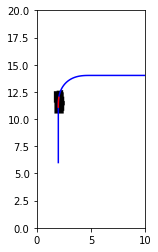

In [ ]:
def swath_footprint(local_path,grid_size):
  #initialize image
  img = np.zeros(grid_size)
  vertices = []
  for xl,yl,tl in local_path:
    rot = np.array([[np.sin(tl), -np.cos(tl)],[np.cos(tl), np.sin(tl)]])
    for vertex in mule_extents:
      rot_vertex = rot @ vertex + np.array([xl, yl])
      vertices.append(rot_vertex)
  vertices = np.array(vertices,dtype='float32')
  hull_vertices = cv2.convexHull(vertices)
  #change hull vertices to grid coords and typecast as int32
  hull_vertices = (hull_vertices//grid_res).astype('int32')
  cv2.fillConvexPoly(img,hull_vertices,1)
  return img.T == 1

s, e = 15, 20
footprint = swath_footprint(ref_path[s:e], grid_data.shape)
plt.imshow(1 - footprint.T, origin='lower', cmap=plt.cm.gray, extent=[x1,x2,y1,y2])
plt.plot(ref_path[:,0], ref_path[:,1],'b-')
plt.plot(ref_path[s:e,0], ref_path[s:e,1],'r-')
plt.xlim(0, 10)
plt.ylim(0, 20)

Once you know the footprint, it should be easy to see if the footprint coincides with any occupied cells in the original grid

Try out some examples to unit test your code for both circle checking and swath checking

In practice, you can write this as a CollisionChecking class where the mule dimensions are read from a config file and initialized. Global variables are best avoided in production code
